In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import glob
from collections import namedtuple
import os
import contextily as ctx
from scipy.spatial import cKDTree
from shapely.geometry import Point, shape, LineString, MultiLineString, GeometryCollection, MultiPoint, Polygon, MultiPolygon  # creating points
import json
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map, thread_map
pd.set_option('min_rows', 30)
import sys
from importlib import reload
from util import *
import matplotlib.pyplot as plt
import multiprocessing
# from pandarallel import pandarallel # parallel operations for speed
# pandarallel.initialize(nb_workers=8, progress_bar=True)
# import swifter
tqdm.pandas()
plt.rcParams['figure.figsize'] = (16, 16)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
gpd.options.use_pygeos 

True

In [4]:
max_workers = 30

In [5]:
ls('restricted')

name  filesize (MB)  \
0  BCs_issued_by_AUP_TLADCs_2021FEB (1).csv          64.34   

               last modified  
0 2021-09-30 13:01:01.848595

Total: 64.0MB


## Setup

In [286]:
%%time
parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb')

parcels = parcels[parcels.land_district.isin(['North Auckland', 'South Auckland'])].to_crs(4326)

parcels['geometry_polygon_4326'] = parcels.geometry
parcels['geometry_polygon_2193'] = parcels.geometry.to_crs(2193)

parcels['geometry_centroid_2193'] = parcels['geometry_polygon_2193'].centroid
parcels['representative_point_2193'] = parcels['geometry_polygon_2193'].representative_point()

parcels['geometry_centroid_4326'] = parcels['geometry_centroid_2193'].to_crs(4326)
parcels['representative_point_4326'] = parcels['representative_point_2193'].to_crs(4326)

parcels.sindex

CPU times: user 1min 31s, sys: 1.66 s, total: 1min 33s
Wall time: 1min 33s


In [7]:
bounds2193 = {}
bounds2193['x1'], bounds2193['y1'], bounds2193['x2'], bounds2193['y2'] = parcels['geometry_polygon_2193'].total_bounds
bounds2193

{'x1': 1628240.6899850937,
 'y1': 5853411.874073706,
 'x2': 1860761.1514916217,
 'y2': 6047518.664558373}

In [39]:
# keep a centroid and polygon version - change between them according to need
parcels_sample = parcels.sample(10000)
parcels_sample['geometry_polygon_2193'] = parcels_sample.geometry.to_crs(2193)
parcels_sample['geometry_centroid_2193'] = parcels_sample.geometry_polygon_2193.centroid
parcels_sample['geometry_centroid_4326'] = parcels_sample.geometry_centroid_2193.to_crs(4326)
parcels_sample['geometry_polygon_4326'] = parcels_sample.geometry_polygon_2193.to_crs(4326)
parcels_sample.sindex

In [40]:
# get a sample of non-road polygons
parcels_sample2 = parcels_sample[parcels_sample.parcel_intent != 'Road'].sample(5)
parcels_sample2.sindex

## 1. LINZ parcel information
##### a. **LINZ_parcel_ID** Parcel identifier - “certificate of title”.


In [22]:
parcels['LINZ_parcel_ID'] = parcels.id

##### b. **LINZ_parcel_centroid_lon**
##### c. **LINZ_parcel_centroid_lat**

In [23]:
parcels['geometry'] = parcels.geometry_centroid_4326
parcels = parcels.set_crs(4326)
parcels['LINZ_parcel_centroid_lon'] = parcels.geometry.x
parcels['LINZ_parcel_centroid_lat'] = parcels.geometry.y

##### d. **LINZ_parcel_vertices_lon** vector of longitudes of the vertices of the matched LINZ parcels 
##### e. **LINZ_parcel_vertices_lat**

In [18]:
%%time

def init_pool(input_data):
    global shared_data
    shared_data = input_data

def extract_verts(geometry):
    lat = np.nan
    lng = np.nan
    if geometry:
        coordinates = []
        for polygon in geometry:
            # the last point is the same as the first
            coordinates.extend(polygon.exterior.coords[:-1])
        lng = f"[{'; '.join([str(round(point[0], 6)) for point in coordinates])}]"
        lat = f"[{'; '.join([str(round(point[1], 6)) for point in coordinates])}]"
    return lng, lat



# lowering chunk size to 1 greatly lengthens time here.
# upping chunk size to 10000 doesn't have much impact
vertices = process_map(extract_verts, parcels.geometry, max_workers=max_workers, chunksize=100)
parcels["LINZ_parcel_vertices_lon"] = [v[0] for v in vertices]
parcels["LINZ_parcel_vertices_lat"] = [v[1] for v in vertices]

  0%|          | 0/537289 [00:00<?, ?it/s]

CPU times: user 1min 22s, sys: 42.6 s, total: 2min 5s
Wall time: 1min 37s


##### f. **LINZ_parcel_roadvertices_lon** subvector of longitudes of parcel that sits adjacent to a road 
##### g. **LINZ_parcel_roadvertices_lat**

In [13]:
parcels['geometry'] = parcels.geometry_polygon_4326
parcels = parcels.set_crs(4326)

In [14]:
roads = parcels[parcels.parcel_intent == "Road"]
roads = roads.to_crs(parcels.crs)

In [15]:
%%time
roads_dissolved = roads.dissolve()

CPU times: user 32.7 s, sys: 0 ns, total: 32.7 s
Wall time: 32.7 s


In [16]:
def pointarray2matarrays(pointarray):
    """list of points to matlab compatible arrays of longs and lats
    
    i.e.
    [point1, point2,...] -> 'point1_x; point2_x; ...', 'point1_y; point2_y; ...'
    """
    lon = [point.xy[0][0] for point in pointarray]
    lat = [point.xy[1][0] for point in pointarray]
    lon = f"[{'; '.join([str(round(lon, 6)) for lon in list(lon)])}]"
    lat = f"[{'; '.join([str(round(lat, 6)) for lat in list(lat)])}]"
    return lon, lat

def init_pool(input_data):
    global shared_data
    shared_data = input_data



def get_points_in_roads(row):
    """return a list of points from the geometry that fall within roads_dissolved"""
    # assume multipolygon
    if row[1].parcel_intent == 'road':
        return None
    geom = row[1].geometry
    assert isinstance(geom, MultiPolygon), f"not implemented for geometry of type {type(geom)}"
    road_points = []
    # iterate over polygons
    for poly in geom:
        # split polygon into vertices
        # the last point is the same as the first
        coords = poly.exterior.coords[:-1]
        pointsx = [x for x, _ in coords]
        pointsy = [y for _, y in coords]
        # create gdf with one row per vertex
        points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(pointsx, pointsy)).set_crs(4326)
        # sjoin with roads, to eliminate vertices that don't intersect a road
        road_points.extend(gpd.sjoin(points_gdf, roads_dissolved, op = 'intersects').geometry.values)
    # split into matlab compatible longs and lats like [(longs_list, lats_list), (longs_list, lats_list),...]
    road_points = pointarray2matarrays(road_points)
    return road_points

In [17]:
%%time
# this might hang for a few minutes before multiprocessing starts
road_intersections = process_map(get_points_in_roads, parcels.iterrows(), max_workers=max_workers, chunksize=100, total=len(parcels))

parcels['LINZ_parcel_roadvertices_lon'] = [r[0] for r in road_intersections]
parcels['LINZ_parcel_roadvertices_lat'] = [r[1] for r in road_intersections]

  0%|          | 0/537289 [00:00<?, ?it/s]

In [ ]:
# example
sample = parcels.iloc[[2065]]
road_points = get_points_in_roads(sample.iloc[0].geometry)
print(road_points)
ax = gpd.GeoDataFrame(geometry=road_points).plot()
sample.plot(ax=ax, alpha=0.5)
roads_dissolved.plot(ax=ax, color='red', alpha=0.5)
x1, y1, x2, y2 = sample.buffer(0.005).total_bounds
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.show()

##### h. **LINZ_adjoining_parcel_ID** id of adjoining LINZ parcels  
##### i. **LINZ_parcel_sides_zones** AUP Zone Code of adjoining parcels (this includes residential, business, and rural zones; it should also include roads, water and open spaces)  
For convenience/speed, 1h and 1i can be gotten simultaneously.  
**Note**: Do 2a and 2b here first, which are needed for 1i.  

What to use for joining parcels with AUP zones?  
- intersect: fails because a parcel's exterior might intersect with an AUP zone's exterior, without any overlap
- overlap: fails because it is false if one polygon is contained completely within the other  
To use polygon/polygon operations, a combination would be needed; something like intersects but does not touch.  
Better to use a representative point - which *may* miss cases when a parcel is spread over two AUP zones (not sure if that occurs).  
Bonus: representative point + within is many, many, many times faster than using intersects + not touches (~10s vs not finishing before killing after at least 30 minutes)

**first, 2a and 2b**

In [8]:
%%time
aup_zones = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_BaseZone.shp')
aup_zones.sindex
aup_zones.sample(3)

CPU times: user 25.8 s, sys: 2.4 s, total: 28.2 s
Wall time: 30.1 s


WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
4323       57767.0  20161111010    None  20160718211       None   
111639         NaN  20161111012    None  20160718211       None   
47139          NaN  20161111011    None  20160718211       None   

                                      GlobalID GROUPZONE   GROUPZONE_    ID  \
4323    {2653E2A1-4629-48CA-AADC-2038EFCAC51E}         2  Residential  None   
111639  {2AFF46AC-8E35-48EC-89C3-D0E18F776D78}         7      General  None   
47139   {1F572D18-2901-44B3-B7FA-5B9F8F71C99A}         5      Coastal  None   

                    NAME  OBJECTID PARCEL_BAS PARCEL_B00 PRECINCT PRECINCT_r  \
4323    Everglade School      4324       None       None     None       None   
111639              None    111640       None       None     None       None   
47139               None     47140       None       None     None       None   

       PRECINCTGR PRECINCT00 SCHEDULE    SHAPE_Area  SHAPE_Leng STATUS  \
4323         None       None     None  25532.898535  745.711232   None   
111639       None       None     None   3452.179432  398.432755   None   
47139        None       None     None      0.835644    5.790642   None   

       SUBPRECINC SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE TYPE_resol VALIDATION  \
4323         None       None    None       None  None       None          3   
111639       None       None    None       None  None       None          3   
47139        None       None    None       None  None       None          3   

              VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
4323    Valid and Public          4  Operative   18   
111639  Valid and Public          4  Operative   27   
47139   Valid and Public          4  Operative   59   

                                       ZONE_resol  ZONEHEIGHT  \
4323    Residential - Mixed Housing Suburban Zone         NaN   
111639                                       Road         NaN   
47139           Coastal - Coastal Transition Zone         NaN   

                                                 geometry  
4323    POLYGON Z ((1768860.282 5903754.262 0.000, 176...  
111639  POLYGON Z ((1757930.155 5916271.915 0.000, 175...  
47139   POLYGON Z ((1750889.741 5924939.607 0.000, 175...

In [ ]:
# use 2193 for AUP; this will be useful later when calculating haversine distances to nearest zones
# representative point is much faster for sjoin
parcels['geometry'] = parcels.representative_point_2193
parcels = parcels.set_crs(2193)
aup_zones = aup_zones.to_crs(parcels.crs)

In [10]:
%%time
parcels_zoned = gpd.sjoin(parcels, aup_zones[['ZONE', 'ZONE_resol', 'geometry']], op='within').drop(columns=['index_right'])

CPU times: user 9.4 s, sys: 247 ms, total: 9.65 s
Wall time: 9.67 s


In [11]:
# check if there was a one to one match
print(len(parcels_zoned.index.unique()))
print(len(parcels_zoned))
print(len(parcels.index.unique()))
print(len(parcels))

537095
537118
537290
537290


In [12]:
# 23 parcels fall have their representative point fall under multiple AUP zone polygons
# but see below, only one of these falls in two AUP zone polygons with different zone codes
np.unique(parcels_zoned.index.value_counts(), return_counts=True)

(array([1, 2]), array([537072,     23]))

In [13]:
%%time
def get_parcel_zones(id):
    if id in parcels_zoned.index:
        zoned = parcels_zoned.loc[[id]]
        # filter out duplicates
        return ','.join(zoned.ZONE.unique())
    else:
        return None
parcel_zones = process_map(get_parcel_zones, list(parcels.index), max_workers=max_workers, chunksize=1000)

  0%|          | 0/537290 [00:00<?, ?it/s]

CPU times: user 2.32 s, sys: 1.49 s, total: 3.81 s
Wall time: 43min 3s


In [14]:
# there is a one to one relationship between zones and zone names
print(len(aup_zones[['ZONE', 'ZONE_resol']].drop_duplicates().ZONE.unique()))
print(len(aup_zones[['ZONE', 'ZONE_resol']].drop_duplicates()))
zone2zone_name = {r.ZONE: r.ZONE_resol for _, r in aup_zones[['ZONE', 'ZONE_resol']].drop_duplicates().iterrows()}

50
50


In [15]:
# only one parcel has its representative point fall in two zones
print([z for z in parcel_zones if z is not None and ',' in z])
print(zone2zone_name['18'])
print(zone2zone_name['19'])

['18,19']
Residential - Mixed Housing Suburban Zone
Residential - Single House Zone


In [16]:
# take the first zone where there are multiple (only one case)
parcels['LINZmatch_AUP_code'] = [z.split(',')[0] if (z is not None) else None for z in parcel_zones]
parcels['LINZmatch_AUP_name'] = [zone2zone_name[z.split(',')[0]] if (z is not None) else None for z in parcel_zones]

**now do 1h & 1i** (now that parcels have zones)

In [17]:
# need polygons, will check for touching neighbours
parcels.geometry = parcels['geometry_polygon_4326']
parcels = parcels.set_crs(4326)

In [ ]:
%%time
# number of rows to process at once
n_rows=100
def find_neighbour_info(i):
    """find neighbours of parcels from i * n_rows to (i+1) * n_rows, then find ids and zones of those neighbouring parcels"""
    neighbour_gdf = gpd.sjoin(parcels.iloc[i*n_rows:min((i+1)*n_rows, len(parcels)-1)], parcels, op='touches')
    neighbour_zones = []
    for idx in neighbour_gdf.index:
        neighbour_ids.append(neighbour_gdf.loc[[idx]].id_right.tolist())
        neighbour_zones.append(neighbour_gdf.loc[[idx]].LINZmatch_AUP_code_right.tolist())
    return neighbour_ids, neighbour_zones
        
# each call to find_neighbours will return two lists like this: [list of neighbour ids], [list of niehgbour zones]
# The final structure will be of shape (n_chunks, 2, n_neighbours), where n_neighbours will vary between lists
parcel_neighbour_chunks = process_map(find_neighbour_info, list(range((int(np.ceil(len(parcels) / n_rows))))), max_workers=max_workers, chunksize=10)

In [ ]:
parcel_neighbour_chunks

In [ ]:
parcels['LINZ_adjoining_parcel_ID'] = [ids for chunk in parcel_neighbour_chunks for ids in chunk[0]]
parcels['LINZ_parcel_sides_zones'] = [zones for chunk in parcel_neighbour_chunks for zones in chunk[1]]

##### j. i. **LINZ_TRNSPWR_ohead_indicator** Indicator (0 or 1) for LINZ parcel located under overhead transpower line. Leave blank otherwise. Note that ‘TRANSLINE’ denotes overhead transmission lines in the GIS dataset, while ‘CABLE’ denotes underground transmission lines and can be ignored. 
##### j. ii. **LINZ_TRNSPWR_ohead_name**  
Note: What name to use? 'descriptio'? 

In [22]:
power = gpd.read_file('input/Transmission_Lines_exTRANSPOWER.zip!Transmission_Lines.shp').to_crs(parcels.crs)
# only interested in overhead
power = power[power['type'] == 'TRANSLINE']
power.sample(3)

OBJECTID MXLOCATION designvolt        status  \
57         59  FHL-RDF-A        110  COMMISSIONED   
204       215  THW-DEV-A          0  COMMISSIONED   
179       190  HAI-TRK-A        220  COMMISSIONED   

                      descriptio       type         Symbol    Shape__Len  \
57        Fernhill - Redclyffe A  TRANSLINE  110 TRANSLINE   8220.801262   
204  Te Hikowhenua - Deviation A  TRANSLINE    0 TRANSLINE   4451.019280   
179        Hairini - Tarukenga A  TRANSLINE  220 TRANSLINE  39633.364821   

                                 GlobalID  \
57   32512d46-2661-40aa-ba02-1349f7e67acc   
204  89b6c544-edfd-4f8f-b11c-9d92790d15f5   
179  dfa12f9c-e814-4bf9-bb2a-439b09f3071d   

                                              geometry  
57   MULTILINESTRING ((176.76291 -39.59946, 176.763...  
204  LINESTRING (174.75874 -41.23430, 174.75698 -41...  
179  MULTILINESTRING ((176.15886 -38.07370, 176.159...

In [25]:
%%time
# get dataframe associating parcel indices with overhead power lines
# alternative approach is to do how='left', then combine on index using group by, but that seems much slower when incorporating the results into the final gdf
power_intersect = gpd.sjoin(parcels, power[['descriptio', 'geometry']]).drop(columns=['index_right'])

CPU times: user 20.4 s, sys: 0 ns, total: 20.4 s
Wall time: 20.4 s


In [26]:
power_intersect.index.value_counts()

377815    10
372782     6
393779     4
250736     4
372310     4
          ..
89244      1
88787      1
83697      1
83567      1
512664     1
Length: 5463, dtype: int64

In [27]:
%%time
def get_powerlines(id):
    if id in power_intersect.index:
        powerlines = power_intersect.loc[[id]]
        # filter out duplicates
        return powerlines.descriptio.unique().tolist()
#         return ','.join(powerlines.descriptio.unique())

    else:
        return None
parcel_powerlines = process_map(get_powerlines, list(parcels.index), max_workers=max_workers, chunksize=1000)
parcels['LINZ_TRNSPWR_ohead_name'] = parcel_powerlines
parcels['LINZ_TRNSPWR_ohead_indicator'] = [int(p is not None) for p in parcel_powerlines]

  0%|          | 0/537289 [00:00<?, ?it/s]

CPU times: user 1.53 s, sys: 5.27 s, total: 6.8 s
Wall time: 6.87 s


array([173.31264657, -37.45722582, 175.90237877, -35.69876457])

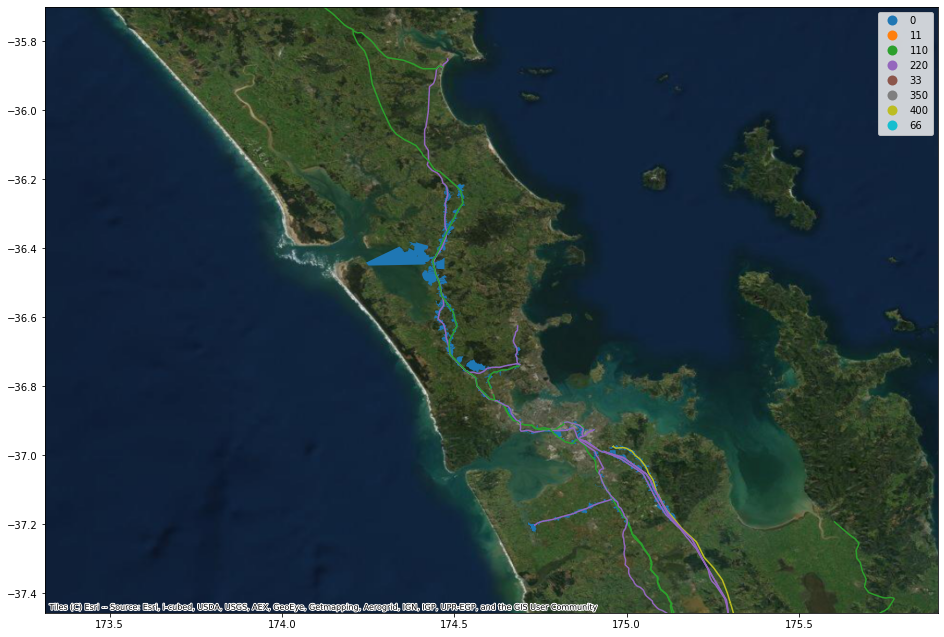

In [36]:
ax = parcels[parcels['LINZ_TRNSPWR_ohead_indicator'] == 1].plot()
power.plot(column='designvolt', legend=True, ax=ax)
plt.xlim((parcels.total_bounds[0], parcels.total_bounds[2]))
plt.ylim((parcels.total_bounds[1], parcels.total_bounds[3]))
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=parcels.crs)

##### k. i. **LINZ_VWSHFT_ohead_indicator** Indicator (0 or 1) for LINZ parcel located under viewshafts. Leave blank otherwise. 
##### k. ii. **LINZ_VWSHFT_ohead_name** Name of the volcanic cone (e.g. Mt Albert). Leave blank if no viewshaft applies. 
##### k. iii. **LINZ_VWSHFT_ohead_ID** OBJECTID of the viewshaft. Leave blank if no viewshaft applies.  

In [10]:
viewshafts_local = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_LocallySignificantVolcanicViewshafts.shp').to_crs(parcels.crs)
viewshafts_regional = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_RegionallySignificantVolcanicViewShaftsAndHeightSensitiveAreasOverlay.shp').to_crs(parcels.crs)
viewshafts_museum = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_AucklandMuseumViewshaftOverlay.shp').to_crs(parcels.crs)

# include dilworth?
viewshafts_dilworth = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_DilworthTerraceHousesViewshaftOverlay.shp').to_crs(parcels.crs)

viewshafts_museum['OBJECTID'] = ['Museum_' + str(s) for s in viewshafts_museum['OBJECTID']]
viewshafts_regional['OBJECTID'] = ['RSVS_' + str(s) for s in viewshafts_regional['OBJECTID']]
viewshafts_local['OBJECTID'] = ['LSVS_' + str(s) for s in viewshafts_local['OBJECTID']]

viewshafts = pd.concat([viewshafts_museum, viewshafts_local, viewshafts_regional])

In [44]:
%%time
joined = gpd.sjoin(parcels, viewshafts[["NAME", "OBJECTID", "geometry"]])

CPU times: user 7.3 s, sys: 211 ms, total: 7.51 s
Wall time: 7.51 s


In [45]:
%%time
def get_viewshafts(id):
    if id in joined.index:
        vs = joined.loc[[id]]
        # filter out duplicates
        return vs["OBJECTID"].unique().tolist(), vs["NAME"].unique().tolist()
    else:
        return None
    
parcel_viewshafts = process_map(get_viewshafts, list(parcels.index), max_workers=max_workers, chunksize=1000)

parcels['LINZ_VWSHFT_ohead_name'] = [vs[1] if vs is not None else None for vs in parcel_viewshafts]
parcels['LINZ_VWSHFT_ohead_ID'] = [vs[0] if vs is not None else None for vs in parcel_viewshafts]
parcels['LINZ_VWSHFT_ohead_indicator'] = [int(p is not None) for p in parcel_viewshafts]

  0%|          | 0/537289 [00:00<?, ?it/s]

CPU times: user 3.02 s, sys: 3.51 s, total: 6.53 s
Wall time: 1min 41s


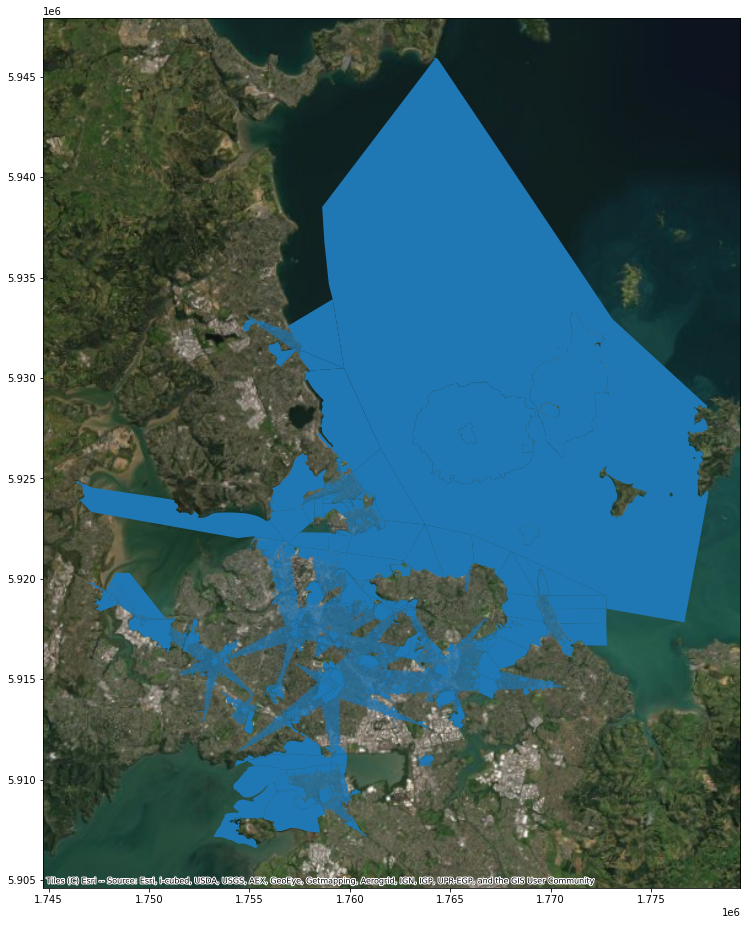

In [47]:
ax = parcels[parcels.LINZ_VWSHFT_ohead_indicator == 1].plot()
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=parcels.crs)

## 2. AUP shapefile information. Calculations are based on centroid of matched parcels: 
##### a. **LINZmatch_AUP_name** AUP zone (string) consent is located in (from the AUP shapefiles) 
##### b. **LINZmatch_AUP_code** AUP Zone Code (numerical) consent is located in   
Done above in 1h and 1i.

##### c. **Hdist_rural** Minimum Haversine distance to nearest Rural Zone,   plus
##### c. i. **Hdist_rural_name** Name of rural zone identified 
##### c. ii. **Hdist_rural_code** Numeric code of rural zone identified  
I've included all of these as rural:  
['Rural - Mixed Rural Zone',  
'Rural - Rural Coastal Zone',  
'Rural - Countryside Living Zone',  
'Rural - Rural Production Zone',  
'Rural - Rural Conservation Zone',  
'Rural - Waitakere Ranges Zone',  
'Rural - Waitakere Foothills Zone']    

In [4]:
%%time
aup_zones = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_BaseZone.shp')
aup_zones = aup_zones.to_crs(2193)
aup_zones.sample(3)

CPU times: user 38.9 s, sys: 3.85 s, total: 42.8 s
Wall time: 49.4 s


WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
102760         NaN  20161111012    None  20160718211       None   
55389          NaN  20161111011    None  20160718211       None   
64035          NaN  20161111011    None  20160718211       None   

                                      GlobalID GROUPZONE   GROUPZONE_    ID  \
102760  {D2CB42B3-4AC0-494F-B7DB-1B625F85309E}         7      General  None   
55389   {7EE47EE9-4168-4027-B43B-AD167FAA578E}         2  Residential  None   
64035   {6204C0B4-9FC2-4450-9C81-1233B9CCD795}         5      Coastal  None   

        NAME  OBJECTID PARCEL_BAS PARCEL_B00 PRECINCT PRECINCT_r PRECINCTGR  \
102760  None    102761       None       None     None       None       None   
55389   None     55390       None       None     None       None       None   
64035   None     64036       None       None     None       None       None   

       PRECINCT00 SCHEDULE    SHAPE_Area  SHAPE_Leng STATUS SUBPRECINC  \
102760       None     None   4820.266107  506.146565   None       None   
55389        None     None  12835.318390  716.757720   None       None   
64035        None     None     10.307124   25.986136   None       None   

       SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE TYPE_resol VALIDATION  \
102760       None    None       None  None       None          3   
55389        None    None       None  None       None          3   
64035        None    None       None  None       None          3   

              VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
102760  Valid and Public          4  Operative   27   
55389   Valid and Public          4  Operative   18   
64035   Valid and Public          4  Operative   30   

                                       ZONE_resol  ZONEHEIGHT  \
102760                                       Road         NaN   
55389   Residential - Mixed Housing Suburban Zone         NaN   
64035       Coastal - General Coastal Marine Zone         NaN   

                                                 geometry  
102760  POLYGON ((1757938.586 5918711.839, 1757928.533...  
55389   POLYGON ((1768405.622 5906733.976, 1768409.836...  
64035   POLYGON ((1714074.272 5961757.993, 1714076.965...

In [16]:
rural_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('rural - ', na=False)]['ZONE'].unique()

In [21]:
# check that each rural zone code matches with a unique rural zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in rural_codes])
# dictionary mapping code to names
rural_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in rural_codes}

In [386]:
aup_zones[aup_zones.ZONE_resol.isna()]

WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
20853          NaN  20161111011    None  20160718211       None   
121765         NaN  20161111010    None  20160718211       None   

                                      GlobalID GROUPZONE  \
20853   {2D83F680-9587-4D57-AF0B-CB7CA27C3D2C}         6   
121765  {FD3E8BB4-1979-42B5-9A77-5D04AE5190AF}         6   

                  GROUPZONE_    ID  NAME  OBJECTID PARCEL_BAS PARCEL_B00  \
20853   Special purpose zone  None  None     20854       None       None   
121765  Special purpose zone  None  None    121766       None       None   

       PRECINCT PRECINCT_r PRECINCTGR PRECINCT00 SCHEDULE  SHAPE_Area  \
20853      None       None       None       None     None   22.286945   
121765     None       None       None       None     None    4.114962   

        SHAPE_Leng STATUS SUBPRECINC SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE  \
20853    72.629617   None       None       None    None       None  None   
121765   86.135341   None       None       None    None       None  None   

       TYPE_resol VALIDATION        VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
20853        None          3  Valid and Public          4  Operative   58   
121765       None          3  Valid and Public          4  Operative   58   

       ZONE_resol  ZONEHEIGHT  \
20853        None         NaN   
121765       None         NaN   

                                                 geometry  
20853   POLYGON Z ((1767684.860 5903714.023 33.721, 17...  
121765  POLYGON Z ((1767684.083 5903713.690 33.721, 17...

In [385]:
# 2 NAs in ZONE_resol are from a zone 58, which only has observations
aup_zones[aup_zones.ZONE == '58']

WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
20853          NaN  20161111011    None  20160718211       None   
121765         NaN  20161111010    None  20160718211       None   

                                      GlobalID GROUPZONE  \
20853   {2D83F680-9587-4D57-AF0B-CB7CA27C3D2C}         6   
121765  {FD3E8BB4-1979-42B5-9A77-5D04AE5190AF}         6   

                  GROUPZONE_    ID  NAME  OBJECTID PARCEL_BAS PARCEL_B00  \
20853   Special purpose zone  None  None     20854       None       None   
121765  Special purpose zone  None  None    121766       None       None   

       PRECINCT PRECINCT_r PRECINCTGR PRECINCT00 SCHEDULE  SHAPE_Area  \
20853      None       None       None       None     None   22.286945   
121765     None       None       None       None     None    4.114962   

        SHAPE_Leng STATUS SUBPRECINC SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE  \
20853    72.629617   None       None       None    None       None  None   
121765   86.135341   None       None       None    None       None  None   

       TYPE_resol VALIDATION        VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
20853        None          3  Valid and Public          4  Operative   58   
121765       None          3  Valid and Public          4  Operative   58   

       ZONE_resol  ZONEHEIGHT  \
20853        None         NaN   
121765       None         NaN   

                                                 geometry  
20853   POLYGON Z ((1767684.860 5903714.023 33.721, 17...  
121765  POLYGON Z ((1767684.083 5903713.690 33.721, 17...

In [15]:
rural = aup_zones[aup_zones.ZONE.isin(rural_codes)]

In [43]:
rural_by_zone_dict = {code: rural[rural.ZONE == code].dissolve() for code in rural_codes}

def find_nearest(item):
    index, row = item
    distance_candidates = []
    code_candidates = []
    for code, rural_gdf in rural_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(rural_gdf.geometry[0]))
        code_candidates.append(rural_gdf.ZONE[0])
    return distance_candidates, code_candidates

# this might hang for a few minutes before multiprocessing starts
output = process_map(find_nearest, parcels_sample.iterrows(), max_workers=max_workers, chunksize=1, total=len(parcels_sample))

# all distances (to any zone)
distance_candidates = np.array([x[0] for x in output])
code_candidates = np.array([x[1] for x in output])

# indices of minimum distances
min_idx = np.argmin(distance_candidates, axis=-1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [40]:
parcels_sample['Hdist_rural'] = distance_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_sample['Hdist_rural_code'] = code_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_sample['Hdist_rural_name'] = parcels_sample.apply(lambda x: rural_code2name[x.Hdist_rural_code], axis=1)

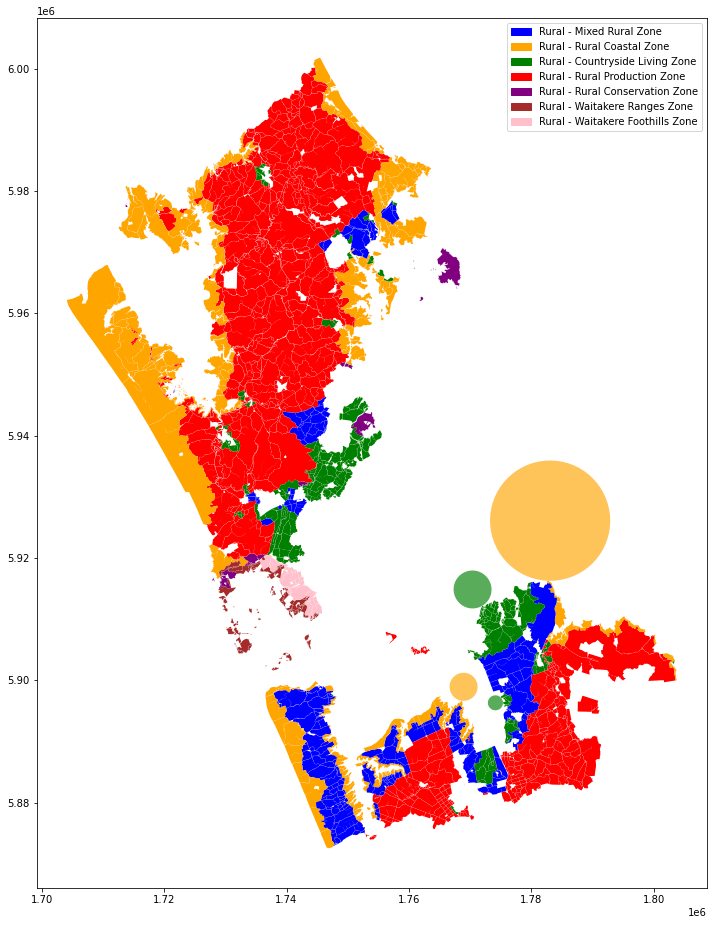

In [42]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan')
name2colour = {name: colour for name, colour in zip(rural_code2name.values(), colours)}

column = 'Hdist_rural'
subsample = parcels_sample[parcels_sample[column] > 0].sample(5)
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']
subsample = subsample[~subsample.is_empty]
# ax = rural.plot(column='ZONE_resol', legend=True)
# subsample.plot(column='Hdist_rural_name', alpha=0.4, ax=ax)
ax = rural.plot(color=[name2colour[z] for z in rural.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_rural_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

# ctx.add_basemap(ax=ax, crs=subsample.crs)

##### d. **Hdist_bus** Minimum Haversine distance to nearest Business Zone
##### d. i. **Hdist_bus_name**
##### d. ii. **Hdist_bus_code**

In [45]:
business_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('business - ', na=False)]['ZONE'].unique()

In [46]:
# check that each business zone code matches with a unique business zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in business_codes])
# dictionary mapping code to names
business_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in business_codes}
business_code2name

{'44': 'Business - Neighbourhood Centre Zone',
 '12': 'Business - Mixed Use Zone',
 '17': 'Business - Light Industry Zone',
 '5': 'Business - Heavy Industry Zone',
 '49': 'Business - General Business Zone',
 '1': 'Business - Business Park Zone',
 '22': 'Business - Town Centre Zone',
 '10': 'Business - Metropolitan Centre Zone',
 '7': 'Business - Local Centre Zone',
 '35': 'Business - City Centre Zone'}

In [47]:
business = aup_zones[aup_zones.ZONE.isin(business_codes)]

In [48]:
business_by_zone_dict = {code: business[business.ZONE == code].dissolve() for code in business_codes}

def find_nearest(item):
    index, row = item
    distance_candidates = []
    code_candidates = []
    for code, business_gdf in business_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(business_gdf.geometry[0]))
        code_candidates.append(business_gdf.ZONE[0])
    return distance_candidates, code_candidates

# this might hang for a few minutes before multiprocessing starts
output = process_map(find_nearest, parcels_sample.iterrows(), max_workers=max_workers, chunksize=1, total=len(parcels_sample))

# all distances (to any zone)
distance_candidates = np.array([x[0] for x in output])
code_candidates = np.array([x[1] for x in output])

# indices of minimum distances
min_idx = np.argmin(distance_candidates, axis=-1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [50]:
parcels_sample['Hdist_bus'] = distance_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_sample['Hdist_bus_code'] = code_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_sample['Hdist_bus_name'] = parcels_sample.apply(lambda x: business_code2name[x.Hdist_bus_code], axis=1)

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan', 'black', 'white')
name2colour = {name: colour for name, colour in zip(business_code2name.values(), colours)}

# hard to see, subset to smaller area
bounds = {'x1': 1.76e6, 'x2': 1.7613e6, 'y1': 5.9123e6, 'y2': 5.914e6}

column = 'Hdist_bus'
subsample = parcels_sample.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']

subsample = subsample[~subsample.is_empty]

business_plot = business.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
ax = business_plot.plot(color=[name2colour[z] for z in business_plot.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_bus_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

ctx.add_basemap(ax=ax, crs=subsample.crs)

##### e. **Hdist_resid** Minimum Haversine distance to nearest Residential Zone,
##### e. i. **Hdist_resid_name**
##### e. ii. **Hdist_resid_code**

In [54]:
resid_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('resid', na=False)]['ZONE'].unique()

In [55]:
resid_codes

array(['60', '23', '18', '8', '19', '20'], dtype=object)

In [56]:
# check that each resid zone code matches with a unique resid zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in resid_codes])
# dictionary mapping code to names
resid_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in resid_codes}
resid_code2name

{'60': 'Residential - Mixed Housing Urban Zone',
 '23': 'Residential - Large Lot Zone',
 '18': 'Residential - Mixed Housing Suburban Zone',
 '8': 'Residential - Terrace Housing and Apartment Building Zone',
 '19': 'Residential - Single House Zone',
 '20': 'Residential - Rural and Coastal Settlement Zone'}

In [57]:
resid = aup_zones[aup_zones.ZONE.isin(resid_codes)]

In [59]:
resid_by_zone_dict = {code: resid[resid.ZONE == code].dissolve() for code in resid_codes}

def find_nearest(item):
    index, row = item
    distance_candidates = []
    code_candidates = []
    for code, gdf in resid_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(gdf.geometry[0]))
        code_candidates.append(gdf.ZONE[0])
    return distance_candidates, code_candidates

# this might hang for a few minutes before multiprocessing starts
output = process_map(find_nearest, parcels_sample.iterrows(), max_workers=max_workers, chunksize=1, total=len(parcels_sample))

# all distances (to any zone)
distance_candidates = np.array([x[0] for x in output])
code_candidates = np.array([x[1] for x in output])

# indices of minimum distances
min_idx = np.argmin(distance_candidates, axis=-1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [60]:
parcels_sample['Hdist_resid'] = distance_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_sample['Hdist_resid_code'] = code_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_sample['Hdist_resid_name'] = parcels_sample.apply(lambda x: resid_code2name[x.Hdist_resid_code], axis=1)

/data/miniconda3/envs/house-upzone/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


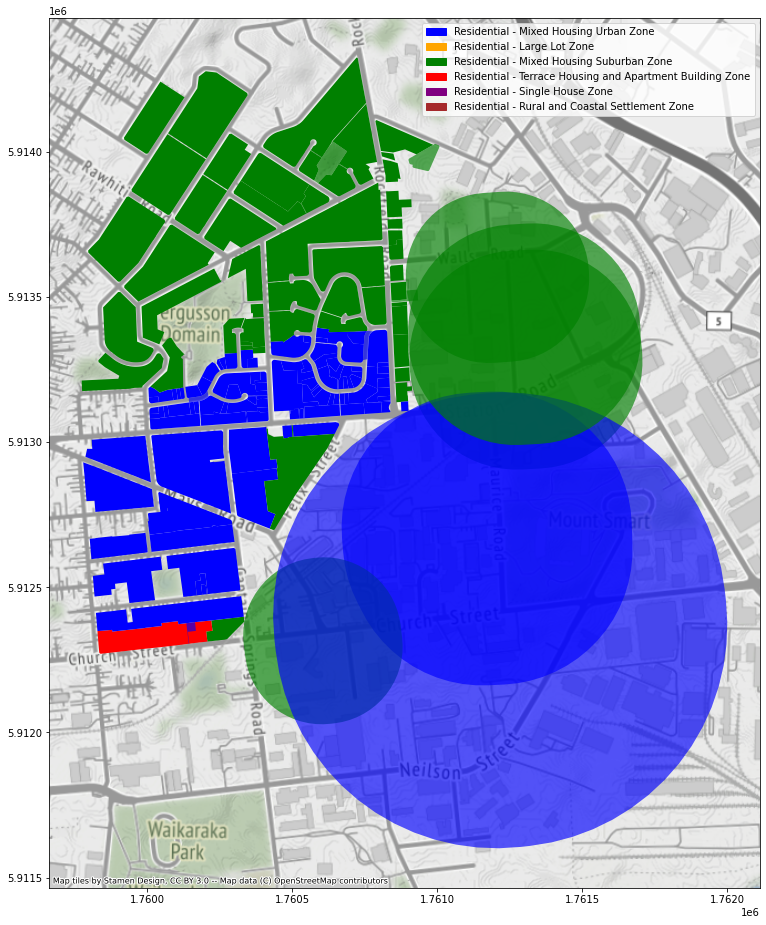

In [61]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan', 'black', 'white')
name2colour = {name: colour for name, colour in zip(resid_code2name.values(), colours)}

# hard to see, subset to smaller area
bounds = {'x1': 1.76e6, 'x2': 1.7613e6, 'y1': 5.9123e6, 'y2': 5.914e6}

column = 'Hdist_resid'
subsample = parcels_sample.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']

subsample = subsample[~subsample.is_empty]

resid_plot = resid.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
ax = resid_plot.plot(color=[name2colour[z] for z in resid_plot.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_resid_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

ctx.add_basemap(ax=ax, crs=subsample.crs)

##### f. **Hdist_SH** Minimum Haversine distance to Residential - Single House Zone 
##### g. **Hdist_MHS** Minimum Haversine distance to Residential - Mixed Housing Suburban Zone
##### h. **Hdist_MHU** Minimum Haversine distance to Residential - Mixed Housing Urban Zone  
##### i. **Zone Hdist_THA** Minimum Haversine distance to Residential - Terrace Housing and Apartments
Note: this is the real name for i: 'Residential - Terrace Housing and Apartment Building Zone'

In [64]:
%%time
postfix2name = {
            'SH': 'Residential - Single House Zone',
            'MHS': 'Residential - Mixed Housing Suburban Zone',
            'MHU': 'Residential - Mixed Housing Urban Zone',
            'THA': 'Residential - Terrace Housing and Apartment Building Zone'
               }
for postfix, zone in tqdm(postfix2name.items()):
    resid_gdf = resid[resid.ZONE_resol == zone].dissolve()
    def get_distance(geo):
        return geo.distance(resid_gdf.geometry[0])
    parcels_sample[f'Hdist_{postfix}'] = process_map(get_distance, parcels_sample.geometry, max_workers=max_workers, chunksize=1)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 48.5 s, sys: 14.3 s, total: 1min 2s
Wall time: 1min 43s


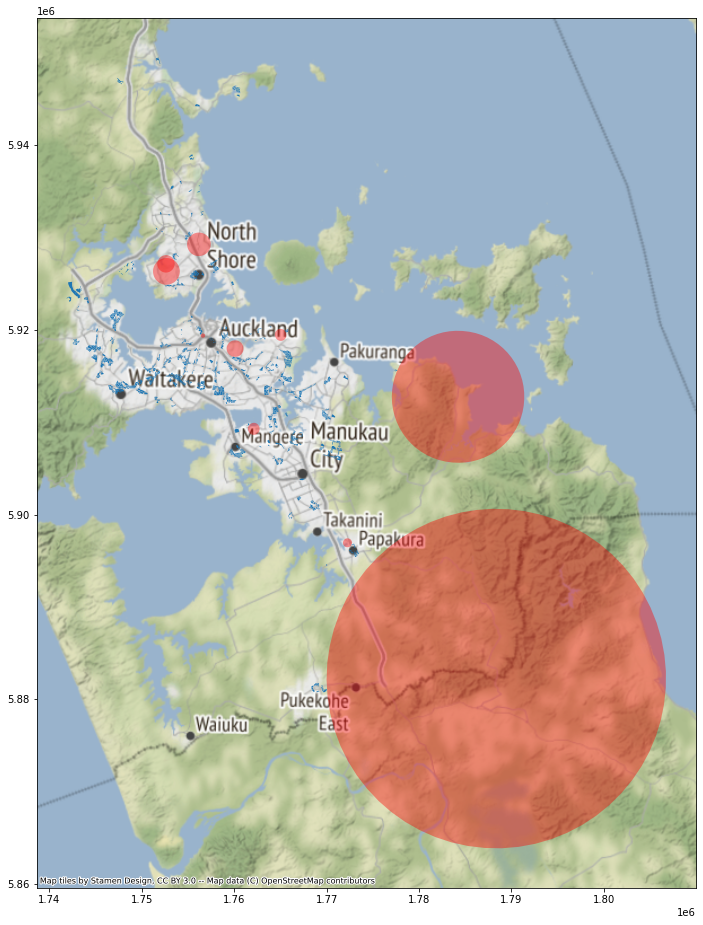

In [65]:
postfix = 'THA'
column = f'Hdist_{postfix}'
subsample = parcels_sample.sample(10)
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']
ax = subsample.plot(color='red', alpha=0.4)
resid[resid.ZONE_resol == postfix2name[postfix]].plot(ax=ax)
ctx.add_basemap(ax, crs=2193)

## 3. Local Area (LA) Information (information on the LA that the consent is located in): 

##### a. Name (just the string is fine; I did not generate numeric codes for the local areas generated) **Local_Area_name**

In [53]:
# parcels['geometry'] = parcels_sample['representative_point_2193']
# parcels = parcels.set_crs(2193)
parcels['geometry'] = parcels['geometry_polygon_2193']
parcels = parcels.set_crs(2193)
LA = gpd.read_file('input/Modified_Community_Boards_SHP.zip').to_crs(parcels.crs)
LA.sample(3)

OBJECTID          Local_Area  \
20       7.0   Franklin-Pukekohe   
24      32.0           Waitakere   
23       4.0  Devonport-Takapuna   

                                             geometry  
20  POLYGON ((1765085.620 5897344.807, 1765096.229...  
24  MULTIPOLYGON (((1743890.310 5905057.188, 17438...  
23  POLYGON ((1755276.581 5932026.336, 1755278.305...

In [58]:
%%time
la_joined_intersects = gpd.sjoin(parcels, LA[['Local_Area', 'geometry']],  how='left').drop(columns=['index_right'])
# la_joined = la_joined.rename(columns={'Local_Area': 'Local_Area_name'})

CPU times: user 29.5 s, sys: 0 ns, total: 29.5 s
Wall time: 29.4 s


In [67]:
la_joined_intersects.index.value_counts()

243564    3
251564    2
444327    2
60035     2
47549     2
         ..
179096    1
179095    1
179094    1
179093    1
537289    1
Length: 537289, dtype: int64

In [64]:
la_joined_touches = gpd.sjoin(parcels, LA[['Local_Area', 'geometry']], op='touches',  how='left').drop(columns=['index_right'])
sum(~la_joined_touches.Local_Area.isna())

0

In [56]:
len(parcels)

537289

## 4. 2018 Statistical Area 2 Information (information on the 2018SA2 that the consent is located in)

##### a. Name (string) **SA22018_name**
##### b. Numeric code **SA22018_code**

In [88]:
parcels['geometry'] = parcels['geometry_polygon_2193']
parcels = parcels.set_crs(2193)
sa2 = gpd.read_file('input/statsnzstatistical-area-2-higher-geographies-2018-clipped-generalis-FGDB.zip!statistical-area-2-higher-geographies-2018-clipped-generalis.gdb').to_crs(parcels.crs)
sa2 = sa2.cx[parcels.total_bounds[0]:parcels.total_bounds[2], parcels.total_bounds[1]:parcels.total_bounds[3]]
sa2.sample(3)

SA22018_V1_00   SA22018_V1_00_NAME REGC2018_V1_00 REGC2018_V1_00_NAME  \
831        134800  Auckland-University             02     Auckland Region   
167        169700              Aka Aka             03      Waikato Region   
72         127200             Akoranga             02     Auckland Region   

    TA2018_V1_00 TA2018_V1_00_NAME  LAND_AREA_SQ_KM  AREA_SQ_KM  Shape_Length  \
831          076          Auckland         0.349028    0.349028   2559.630307   
167          013  Waikato District       186.866328  186.866328  81675.920196   
72           076          Auckland         1.162911    1.162911   5677.981684   

                                              geometry  
831  MULTIPOLYGON (((1758103.070 5920156.227, 17581...  
167  MULTIPOLYGON (((1760586.119 5878080.180, 17607...  
72   MULTIPOLYGON (((1757115.362 5926002.753, 17571...

In [89]:
%%time
sa2_joined = gpd.sjoin(parcels, sa2[['SA22018_V1_00_NAME', 'SA22018_V1_00', 'geometry']], how = 'left').drop(columns=['index_right'])
# parcels_sample = parcels_sample.rename(columns={'SA22020_V1_00_NAME': 'SA22018_name', 'SA22020_V1_00': 'SA22018_code'})

CPU times: user 10.6 s, sys: 12.4 ms, total: 10.6 s
Wall time: 10.6 s


In [90]:
sa2_joined.id.value_counts()

5263213    3
5267478    3
5259034    3
5258938    3
7756058    3
          ..
5056189    1
5056188    1
5056185    1
5056183    1
7266268    1
Name: id, Length: 537289, dtype: int64

## 5. Area Unit Information (information on the 2013AU  that the consent is located in):

##### a. Name (string) **AU2013_name**
##### b. Numeric code **AU2013_code**

In [94]:
parcels['geometry'] = parcels['geometry_polygon_2193']
parcels = parcels.set_crs(2193)
au2013 = gpd.read_file('input/area-unit-2013.gdb.zip').to_crs(parcels.crs)
au2013 = au2013.cx[parcels.total_bounds[0]:parcels.total_bounds[2], parcels.total_bounds[1]:parcels.total_bounds[3]]
au2013.sample(3)

AU2013_V1_00 AU2013_V1_00_NAME  AREA_SQ_KM  LAND_AREA_SQ_KM  Shape_Length  \
677       506616      Matheson Bay    0.368167         0.368167   2786.856493   
971       526106         Pukeoware    7.710337         7.710337  15038.330837   
695       513012      Palm Heights    1.340000         1.340000   6437.104338   

                                              geometry  
677  MULTIPOLYGON (((1761531.956 5981834.395, 17618...  
971  MULTIPOLYGON (((1757326.547 5876690.795, 17574...  
695  MULTIPOLYGON (((1743484.073 5916341.096, 17434...

In [ ]:
%%time
# parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
au2013_joined = gpd.sjoin(parcels, au2013[['AU2013_V1_00_NAME', 'AU2013_V1_00', 'geometry']]).drop(columns=['index_right'])
# parcels_sample = parcels_sample.rename(columns={'AU2013_V1_00_NAME': 'AU2013_name', 'AU2013_V1_00': 'AU2013_code'})

CPU times: user 36.1 s, sys: 0 ns, total: 36.1 s
Wall time: 36.1 s


In [ ]:
np.unique(au2013_joined.index.value_counts(), return_counts=True)

(array([1, 2, 3, 4, 5]), array([9588,  390,   18,    3,    1]))

## 6. 2018 Meshblock Information (information on the 2018MB  that the consent is located in):

##### a. Code **MB2018_code**

In [293]:
parcels['geometry'] = parcels['geometry_polygon_2193']
parcels = parcels.set_crs(2193)
mb2018 = gpd.read_file('input/meshblock-2018-clipped-generalised.gdb.zip').to_crs(parcels.crs)
mb2018 = mb2018.cx[parcels.total_bounds[0]:parcels.total_bounds[2], parcels.total_bounds[1]:parcels.total_bounds[3]]
mb2018.sindex
mb2018.sample(3)

MB2018_V1_00 LANDWATER LANDWATER_NAME  LAND_AREA_SQ_KM  AREA_SQ_KM  \
12027      0475701        12       Mainland         0.035310    0.035310   
16099      0787300        12       Mainland         0.048876    0.048876   
45242      4003119        12       Mainland         0.026548    0.026548   

       SHAPE_Length                                           geometry  
12027   1030.277205  MULTIPOLYGON (((1765587.252 5917453.815, 17656...  
16099    904.521627  MULTIPOLYGON (((1764357.791 5910137.795, 17644...  
45242    806.786397  MULTIPOLYGON (((1744292.333 5915007.121, 17445...

In [349]:
# set up parameters for the following cell
gdf = parcels
area_gdf = mb2018
area_code_col = 'MB2018_V1_00'

In [350]:
# join
joined = gpd.sjoin(gdf, area_gdf[[area_code_col, 'geometry']], how='left').drop(columns=['index_right'])

# find how many times each index value appears
# more than one appearence indicates more than one area has been matched
n_matched = joined.index.value_counts()
# get indices with more than one match
ambiguous_idx = n_matched[n_matched > 1].index

print(len(ambiguous_idx), 'parcels matched to multiple areas')

def find_greatest_area_match(idx):
    """find the overlapping area with the greatest area"""
    # get the corresponding parcel
    parcel = gdf.loc[[idx]]
    # get the matching areas
    matching = area_gdf[area_gdf[area_code_col].isin(joined.loc[idx][area_code_col])]
    # break into distinct regions
    overlaid = gpd.overlay(parcel, matching)
    return overlaid.loc[np.argmax(overlaid.area)][area_code_col]

area_matches = process_map(find_greatest_area_match, ambiguous_idx, max_workers=max_workers, chunksize=10)

# keep first row of groups of duplicates indexes
joined = joined[~joined.index.duplicated(keep='first')]
# replace area code with that with largest overlap
joined.loc[ambiguous_idx, area_code_col] = area_matches

122200 parcels matched to multiple areas


  0%|          | 0/122200 [00:00<?, ?it/s]

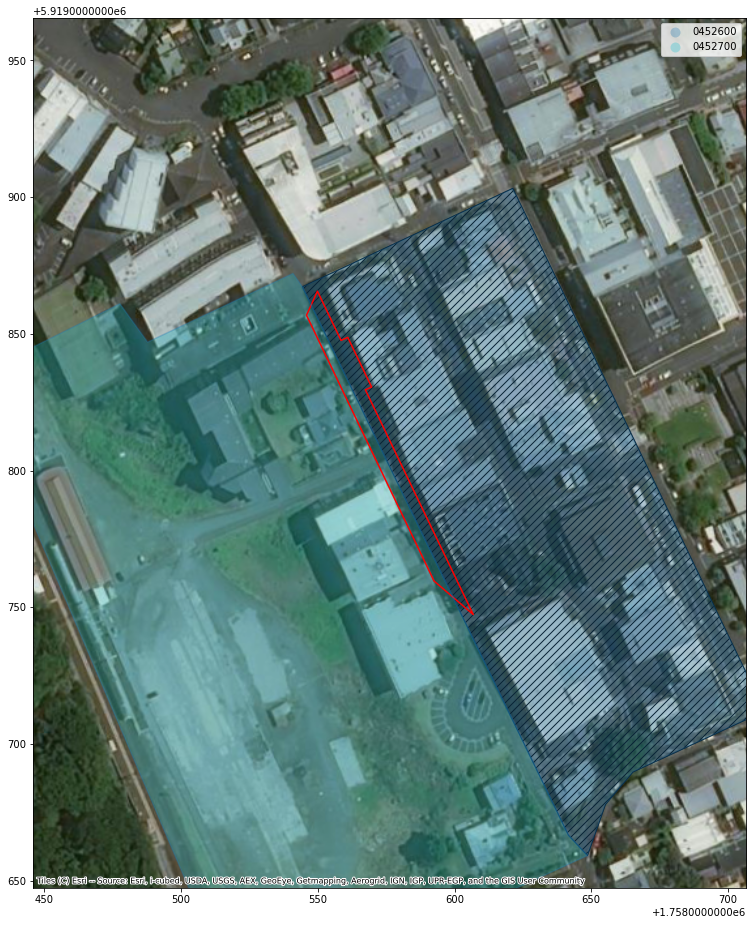

In [352]:
# red outline: parcel
# hatched: largest overlapping meshblock
# others: meshblocks that intersect the parcel
plot_idx = ambiguous_idx[np.random.randint(len(ambiguous_idx))]
plot_gdf = gdf.loc[[plot_idx]]
plot_mb = gpd.sjoin(area_gdf[[area_code_col, 'geometry']], plot_gdf).drop(columns=['index_right'])

plot_bounds = plot_gdf.buffer(100).total_bounds

ax = area_gdf[area_gdf[area_code_col] == joined.loc[plot_idx][area_code_col]].plot(facecolor='None',hatch= "///")
plot_gdf.boundary.plot(color='red', ax=ax)

plot_mb.boundary.plot(ax=ax, alpha=0.3)
plot_mb.plot(ax=ax, column=area_code_col, legend=True, alpha=0.3)

plt.xlim((plot_bounds[0], plot_bounds[2]))
plt.ylim((plot_bounds[1], plot_bounds[3]))

ctx.add_basemap(ax, crs=plot_gdf.crs, source=ctx.providers.Esri.WorldImagery)

## 7. 2013 Meshblock Information (information on the 2013MB  that the consent is located in):

##### a. Code **MB2013_code**

In [169]:
mb2013 = gpd.read_file('input/meshblock-2013.gdb.zip').to_crs(parcels.crs)
mb2013 = mb2013.cx[parcels.total_bounds[0]:parcels.total_bounds[2], parcels.total_bounds[1]:parcels.total_bounds[3]]
mb2013.sample(3)

Meshblock MeshblockNumber AreaUnitCode                 AreaUnitName  \
10569  MB 0147302         0147302       617000  Inlet-Kaipara Harbour North   
15758  MB 0502602         0502602       516500                  Mission Bay   
1010   MB 0134600         0134600       504900                      Kaiwaka   

      UrbanAreaCode    UrbanAreaType          UrbanAreaName TLACode  \
10569           506  Inlet-not in TA        Inlet-not in TA     999   
15758           004  Main Urban Area  Central Auckland Zone     076   
1010            501     Rural Centre           Rural Centre     003   

                                  TLAName WardCode           WardName  \
10569  Area Outside Territorial Authority    99999  Area Outside Ward   
15758                            Auckland    07608        Orakei Ward   
1010                     Kaipara District    00303      Otamatea Ward   

      CommunityBoardCode       CommunityBoardName TLASubdivisionCode  \
10569              99999   Area Outside Community              99999   
15758              07614  Orakei Local Board Area              07699   
1010               00399   Area Outside Community              00399   

             TLASubdivisionName RegionalCouncilCode RegionalCouncilName  \
10569  Area Outside Subdivision                  01    Northland Region   
15758  Area Outside Subdivision                  02     Auckland Region   
1010   Area Outside Subdivision                  01    Northland Region   

      GeneralConstituencyCode                     GeneralConstituencyName  \
10569                    0103                        Kaipara Constituency   
15758                    0299  Area Outside Regional Council Constituency   
1010                     0103                        Kaipara Constituency   

      MaoriConstituencyCode            MaoriConstituencyName  \
10569                  0199  Area Outside Maori Constituency   
15758                  0299  Area Outside Maori Constituency   
1010                   0199  Area Outside Maori Constituency   

      GeneralElectoralDistrictCode_2007 GeneralElectoralDistrictName_2007  \
10569                               034                         Northland   
15758                               048                            Tamaki   
1010                                034                         Northland   

      MaoriElectoralDistrictCode_2007 MaoriElectoralDistrictName_2007  \
10569                               5                  Te Tai Tokerau   
15758                               3                 Tamaki Makaurau   
1010                                5                  Te Tai Tokerau   

      LandCode LandDescription  LandAreaSQKM Meshblock_1   Shape_Length  \
10569       22           Inlet      0.000000        None  104716.466012   
15758       12        Mainland      0.026765        None     800.207514   
1010        12        Mainland      1.653273        None    7854.231630   

                                                geometry  
10569  MULTIPOLYGON (((1723419.010 6002781.406, 17234...  
15758  MULTIPOLYGON (((1763514.799 5919487.037, 17635...  
1010   MULTIPOLYGON (((1727673.917 5998323.059, 17276...

In [87]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample = gpd.sjoin(parcels_sample, mb2013[['MeshblockNumber', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'MeshblockNumber': 'MB2013_code'})

CPU times: user 11.4 s, sys: 7.05 ms, total: 11.4 s
Wall time: 11.4 s


## 8. Additional distance information from consent location  
For these distance calculations, use EPSG 2193 (less distortion).

In [116]:
parcels_sample['geometry'] = parcels_sample['geometry_centroid']
parcels_sample = parcels_sample.to_crs(2193)
parcels_sample.sample(3)

id       appellation      affected_surveys     parcel_intent  \
102782  4896031    Lot 1 DP 61837              DP 61837              DCDB   
119786  4931702   Lot 4 DP 166054             DP 166054              DCDB   
362342  7415715  Lot 23 DP 455616  DP 455616, DP 462513  Fee Simple Title   

       topology_type statutory_actions   land_district     titles  \
102782       Primary              None  North Auckland  NA17C/935   
119786       Primary              None  North Auckland  NA100D/34   
362342       Primary              None  North Auckland     586776   

        survey_area  calc_area                         geometry  \
102782        685.0      685.0  POINT (1773608.374 5914596.096)   
119786      52130.0    50575.0  POINT (1783027.533 5889659.615)   
362342        103.0      103.0  POINT (1763989.858 5916157.717)   

                  geometry_centroid  \
102782  POINT (174.94849 -36.89867)   
119786  POINT (175.06020 -37.12153)   
362342  POINT (174.84025 -36.88632)   

                                         geometry_polygon      SA22018_name  \
102782  MULTIPOLYGON (((174.94827 -36.89874, 174.94841...        Cockle Bay   
119786  MULTIPOLYGON (((175.06295 -37.12105, 175.06293...           Ararimu   
362342  MULTIPOLYGON (((174.84016 -36.88629, 174.84020...  Stonefields West   

       SA22018_code MB2013_code MB2018_code  AU2013_name AU2013_code  
102782       153400     0655102     0655102   Cockle Bay      521502  
119786       166400     0815302     0815302        Hunua      521132  
362342       144900     0465305     4000293  Stonefields      517202

#### a. Minimum Haversine distance to coastline **Hdist_coast**  
There are a few different datasets that could be used for this:  
    - NZ Coastlines (Topo 1:50k) https://data.linz.govt.nz/layer/50258-nz-coastlines-topo-150k/
    - NZ Coastline - mean high water https://data.linz.govt.nz/layer/105085-nz-coastline-mean-high-water/
    - NZ Coastlines and Islands Polygons (Topo 1:50k) https://data.linz.govt.nz/layer/51153-nz-coastlines-and-islands-polygons-topo-150k/  

The first doesn't have islands (e.g. Waiheke).  
The second is probably most appropriate.

In [46]:
%%time
coastline = gpd.read_file('input/lds-nz-coastline-mean-high-water-FGDB.zip!nz-coastline-mean-high-water.gdb').to_crs(2193)
coastline = coastline.cx[bounds2193['x1']:bounds2193['x2'], bounds2193['y1']:bounds2193['y2']]
coastline_dissolved = coastline.dissolve()

CPU times: user 3.73 s, sys: 144 ms, total: 3.87 s
Wall time: 4.05 s


In [47]:
%%time
def extract_coastal_dist(geom):
    return geom.distance(coastline_dissolved.geometry[0])

parcels_sample['Hdist_coast'] = process_map(extract_coastal_dist, parcels_sample.geometry, max_workers=max_workers, chunksize=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 2.57 s, sys: 1.08 s, total: 3.65 s
Wall time: 13.3 s


<AxesSubplot:>

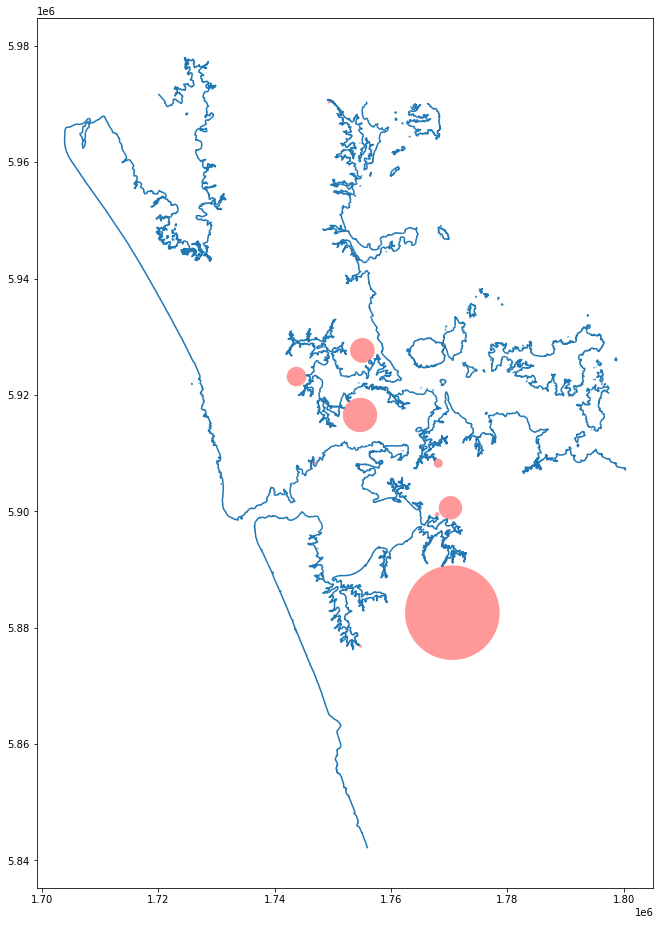

In [48]:
# if distance work, then red circles should extend to the nearest coastline, and no further
subsample = parcels_sample.sample(10)
subsample['coast_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_coast), axis=1)
subsample['geometry'] = subsample['coast_buffer']
ax = subsample.plot(color='red', alpha=0.4)
coastline.cx[1.7e6:1.8e6, 5.85e6:5.97e6].plot(ax=ax)

##### b. Minimum Haversinedistance to Open Space(set of AUP Zones) **Hdist_open**

##### c. Minimum Haversine distance to motorway **Hdist_motorway**
##### d. Minimum Haversine distance to main arterial road **Hdist_main_road**

In [15]:
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample = parcels_sample.set_crs(2193)

In [16]:
roads = gpd.read_file('input/lds-nz-road-centrelines-topo-150k-FGDB.zip!nz-road-centrelines-topo-150k.gdb').to_crs(2193)
roads = roads.cx[bounds2193['x1']:bounds2193['x2'], bounds2193['y1']:bounds2193['y2']]
highways = roads[~roads.hway_num.isna()]
highways_dissolved = highways.dissolve()
arterial_roads = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_ArterialRoad.shp').to_crs(2193)
arterial_roads_dissolved = arterial_roads.dissolve()

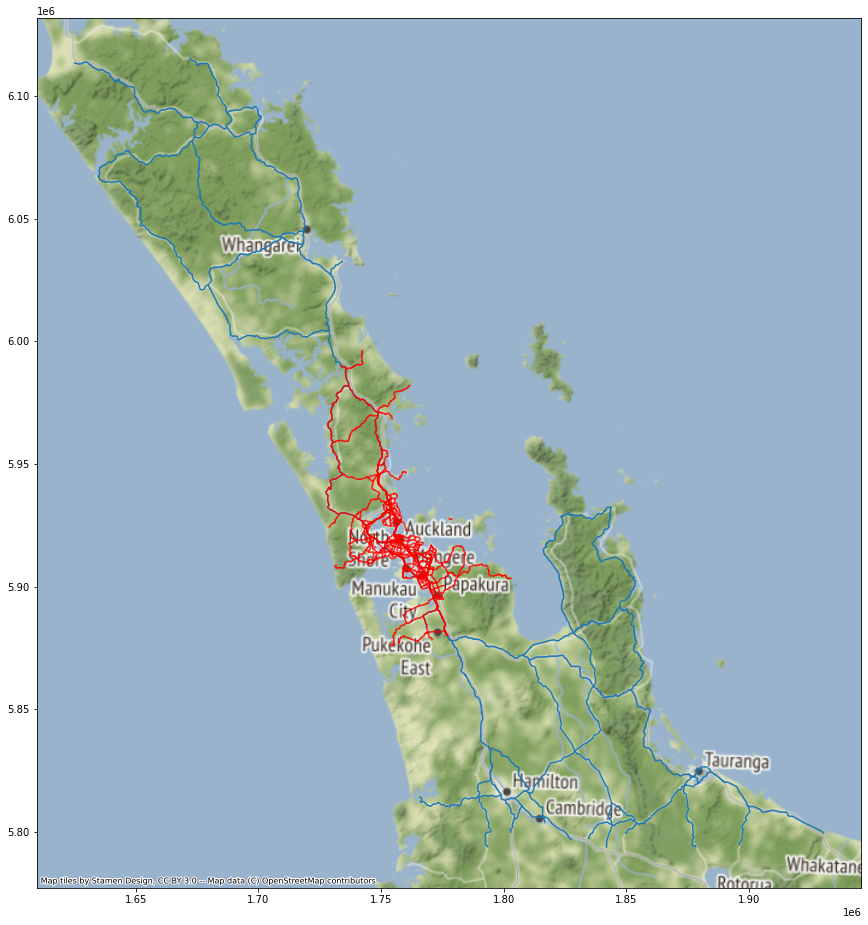

In [17]:
ax = highways.plot()
arterial_roads.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs=2193)

In [22]:
def extract_highway_dist(geom):
    return geom.distance(highways_dissolved.geometry[0])

def extract_main_road_dist(geom):
    return geom.distance(arterial_roads_dissolved.geometry[0])

# parcels_sample['Hdist_motorway'] = parcels_sample.progress_apply(lambda x: x.geometry.distance(highways_dissolved.geometry[0]), axis=1)
parcels_sample['Hdist_motorway'] = process_map(extract_highway_dist, parcels_sample.geometry, max_workers=max_workers, chunksize=10)
# parcels_sample['Hdist_main_road'] = parcels_sample.progress_apply(lambda x: x.geometry.distance(arterial_roads_dissolved.geometry[0]), axis=1)
parcels_sample['Hdist_main_road'] = process_map(extract_main_road_dist, parcels_sample.geometry, max_workers=max_workers, chunksize=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:>

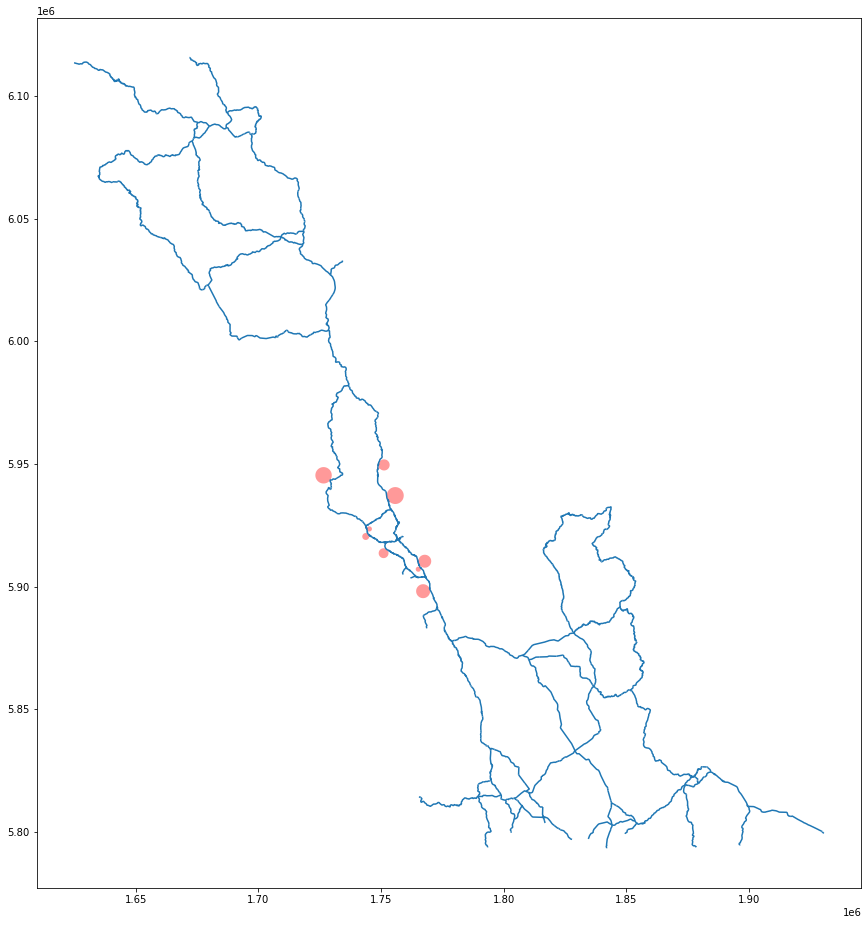

In [23]:
# if distance work, then red circles should extend to the nearest coastline, and no further
subsample = parcels_sample.sample(10)
subsample['highway_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_motorway), axis=1)
subsample['geometry'] = subsample['highway_buffer']
ax = subsample.plot(color='red', alpha=0.4)
highways.plot(ax=ax)

##### e. Minimum Haversine distance to rail line **Hdist_rail**

In [24]:
railroads = gpd.read_file('input/lds-nz-railway-centrelines-topo-150k-SHP.zip').to_crs(2193)
railroads = railroads.cx[bounds2193['x1']:bounds2193['x2'], bounds2193['y1']:bounds2193['y2']]
railroads_dissolved = railroads.dissolve()

In [25]:
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample = parcels_sample.set_crs(2193)
def get_rail_distance(geom):
    return geom.distance(railroads_dissolved.geometry[0])

parcels_sample['Hdist_rail'] = process_map(get_rail_distance, parcels_sample.geometry, max_workers=max_workers, chunksize=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

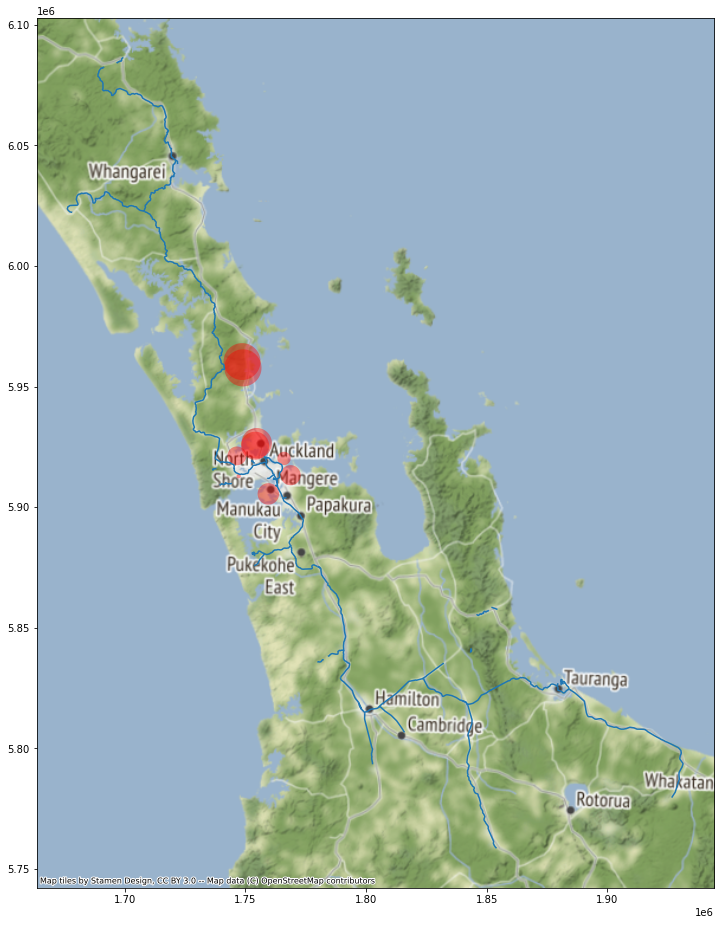

In [27]:
subsample = parcels_sample.sample(10)
subsample['rail_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_rail), axis=1)
subsample['geometry'] = subsample['rail_buffer']
ax = subsample.plot(color='red', alpha=0.4)
railroads_dissolved.plot(ax=ax)
ctx.add_basemap(ax, crs=2193)

##### f. Haversine distance to downtown (use Skytower coordinates) **Hdist_skytower**

In [11]:
skytower = [-36.84838748948485, 174.7621736911587]
skytower = gpd.points_from_xy(x=[skytower[1]], y=[skytower[0]])
skytower = gpd.GeoDataFrame([{"name": "Skytower", "value": 1}], geometry=skytower, crs="EPSG:4326").to_crs(epsg=2193)

In [28]:
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample = parcels_sample.set_crs(2193)

def get_skytower_distance(geom):
    return geom.distance(skytower.geometry[0])

parcels_sample['Hdist_skytower'] = process_map(get_skytower_distance, parcels_sample.geometry, max_workers=max_workers, chunksize=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

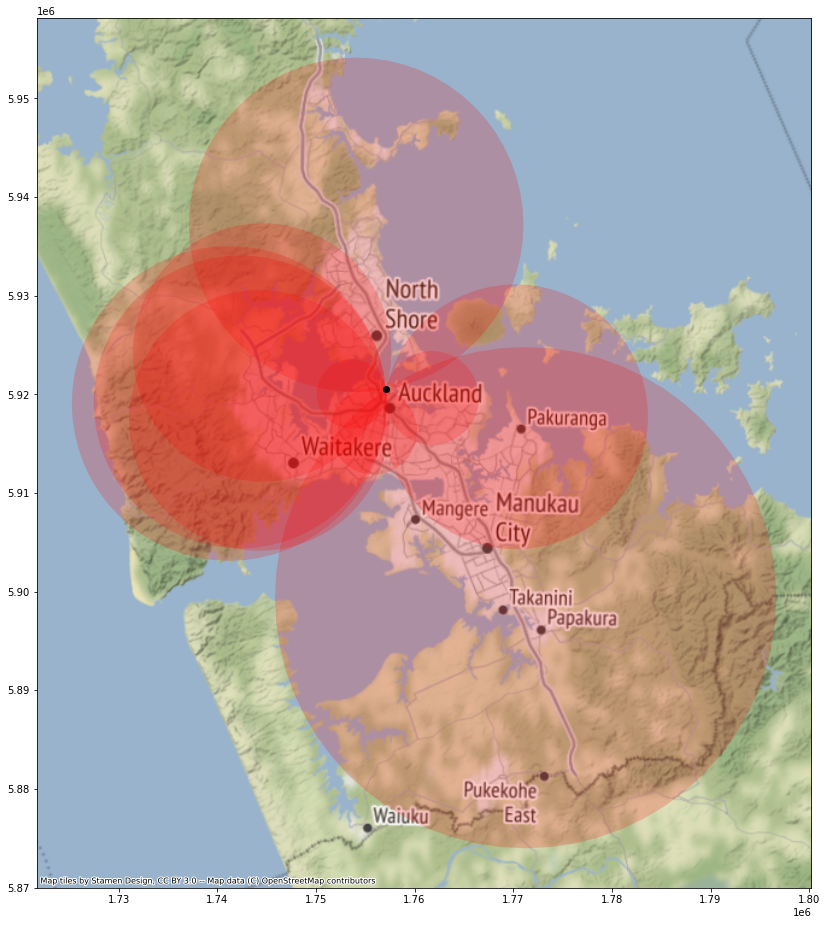

In [31]:
# if distance works, then red circles should extend to the nearest sky tower, and no further
subsample = parcels_sample.sample(10)
subsample['skytower_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_skytower), axis=1)
subsample['geometry'] = subsample['skytower_buffer']
ax = subsample.plot(color='red', alpha=0.2)
skytower.plot(ax=ax, color='black')
ctx.add_basemap(ax, crs=parcels_sample.crs)

## 9. Special Housing Area (SpHAs)
Indicator (1 or 0) for consent located in SpHAs **SpHA_indicator**  
Note: here I've used centroids. Maybe should use parcel polygons instead.

In [32]:
spha = gpd.read_file('input/AC_Special_Housing_Area.zip').to_crs(2193)
spha_dissolved = spha.dissolve()
assert(len(spha_dissolved) == 1)

In [40]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample = parcels_sample.set_crs(2193)

def get_spha_indicator(geom):
    return spha_dissolved.geometry.contains(geom)[0]

parcels_sample['SpHA_indicator'] = process_map(get_spha_indicator, parcels_sample.geometry, max_workers=max_workers, chunksize=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 1.99 s, sys: 1.22 s, total: 3.22 s
Wall time: 7.4 s


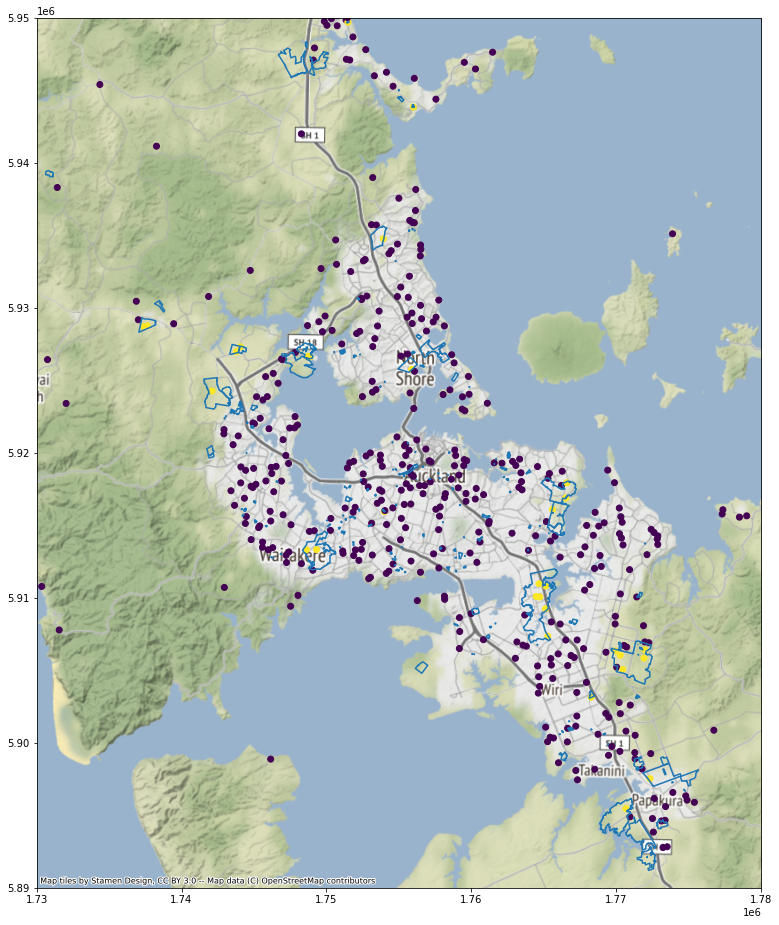

In [44]:
subsample = parcels_sample.sample(500)
ax=subsample.plot(column='SpHA_indicator')
plt.ylim((5.89e6, 5.95e6))
plt.xlim((1.73e6, 1.78e6))
spha_dissolved.boundary.plot(ax=ax)
ctx.add_basemap(ax, crs=spha_dissolved.crs)

## 10. Ranged Address Indicator

## 11. Matching Type Indicators
##### a. LINZ_MATCH_CODE
##### b. LINZ_2ND_MATCH_CODE